In [1]:
pip install opencv-python numpy matplotlib tensorflow

In [6]:

import cv2
import base64
import numpy as np
from PIL import Image
import io
from IPython.display import display, Javascript
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow

<IPython.core.display.Javascript object>

Capturing frame 1/3...


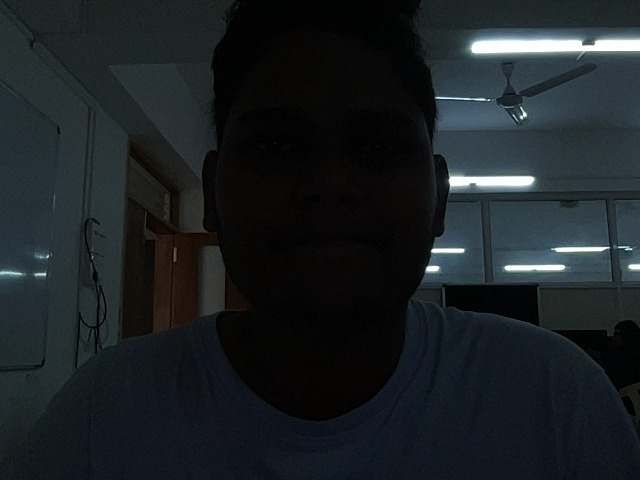

Frame displayed.
Capturing frame 2/3...


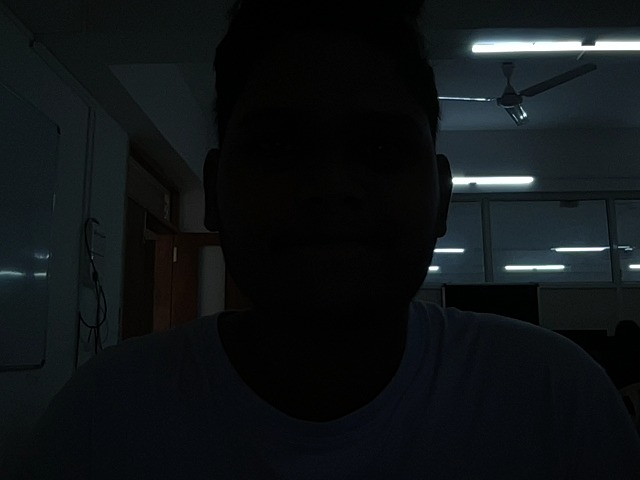

Frame displayed.
Capturing frame 3/3...


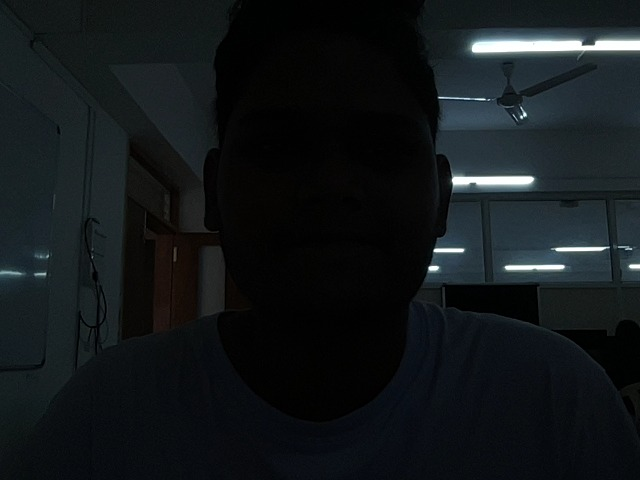

Frame displayed.
Finished capturing and processing frames.


In [12]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow # Import the special Colab display function
from google.colab.output import eval_js
from IPython.display import display, Javascript
from PIL import Image
import io
import base64

# JavaScript code to capture a photo using the webcam
js_code = '''
function initCamera() {
    return new Promise((resolve, reject) => {
        const video = document.createElement('video');
        video.style.display = 'none';
        document.body.appendChild(video);
        const streamPromise = navigator.mediaDevices.getUserMedia({video: true});
        streamPromise.then((stream) => {
            video.srcObject = stream;
            video.onloadedmetadata = () => {
                // Ensure video is playing and ready before resolving
                video.play();
                resolve(video);
            };
        }).catch((error) => {
            reject(error);
        });
    });
}

async function takePhoto() {
    // Only initialize camera once if you plan to take multiple photos
    // For this single-shot example, we init and take, then close.
    const video = await initCamera();
    const canvas = document.createElement('canvas');
    canvas.width = video.videoWidth;
    canvas.height = video.videoHeight;
    const context = canvas.getContext('2d');
    context.drawImage(video, 0, 0, canvas.width, canvas.height);
    const img = canvas.toDataURL('image/jpeg');

    // Stop the camera stream after taking a photo to release resources
    if (video.srcObject) {
        video.srcObject.getTracks().forEach(track => track.stop());
    }
    video.remove(); // Clean up video element
    return img;
}

// Function to take multiple photos for a continuous stream like experience
// This function needs to be slightly different if you want to keep the camera
// open and just grab frames. For simplicity, we'll keep the single 'takePhoto'
// which initializes and then closes. If you need a true stream, the JS would
// need to manage the video element persistently.
'''

display(Javascript(js_code))

# Function to convert JavaScript captured image to OpenCV format
def js_to_image(js_reply):
    if not js_reply: # Handle cases where js_reply might be empty or invalid
        return None
    image_bytes = base64.b64decode(js_reply.split(',')[1])
    image_PIL = Image.open(io.BytesIO(image_bytes))
    image_np = np.array(image_PIL)
    frame = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)
    return frame

# Load the pre-trained face detection model
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# --- Modified Section ---

# In Colab, you typically capture a single image or a small sequence
# rather than a continuous interactive video stream with a 'while True' loop
# that waits for key presses.

# Let's define how many frames you want to capture and process.
# For a "live" feel, you might capture a few frames in quick succession.
# Or, if you just want one photo, call takePhoto() once.

num_frames_to_capture = 3 # Adjust as needed. More frames mean more prompts for webcam access.

for i in range(num_frames_to_capture):
    print(f"Capturing frame {i+1}/{num_frames_to_capture}...")
    try:
        # Capture image using the webcam
        js_reply = eval_js('takePhoto()')
        frame = js_to_image(js_reply)

        if frame is None:
            print(f"Skipping frame {i+1} due to capture error.")
            continue

        # Convert the image to grayscale for face detection
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Detect faces in the image
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)

        # Draw rectangles around detected faces
        for (x, y, w, h) in faces:
            cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 255, 0), 2)

        # Display the image with detected faces
        # Each call to cv2_imshow will create a new output image below the cell.
        cv2_imshow(frame)
        print("Frame displayed.")

    except Exception as e:
        print(f"An error occurred during frame {i+1} capture or processing: {e}")
        # This can happen if webcam access is denied or there's a JS issue.
        break # Exit the loop if an error occurs

print("Finished capturing and processing frames.")

# Removed: cv2.waitKey() and cv2.destroyAllWindows()
# These are not needed/functional in Colab for interactive display.

In [13]:
import cv2
import os
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Path to your dataset
dataset_path = '/content/data'
class_names = ['happy', 'sad']  # replace with your class names

# Initialize data and labels lists
data = []
labels = []

# Load images
for class_index, class_name in enumerate(class_names):
    folder_path = os.path.join('data', class_name)
    for image_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_name)
        if not image_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):  # Check for valid image formats
            print(f"Skipping non-image file: {image_name}")
            continue
        image = cv2.imread(image_path)
        if image is None:
            print(f"Failed to load image: {image_path}")  # Print an error message
            continue
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
        image = cv2.resize(image, (128, 128))  # Resize images to 128x128 pixels
        data.append(image)
        labels.append(class_index)

# Convert lists to numpy arrays
data = np.array(data, dtype="float") / 255.0  # Normalize pixel values
data = np.expand_dims(data, axis=-1)  # Add a channel dimension
labels = np.array(labels)

# One-hot encode the labels
labels = to_categorical(labels, num_classes=2)

# Split the dataset into training and testing sets
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=42)


FileNotFoundError: [Errno 2] No such file or directory: 'data/happy'